### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 📜 Notebook At a Glance</p>

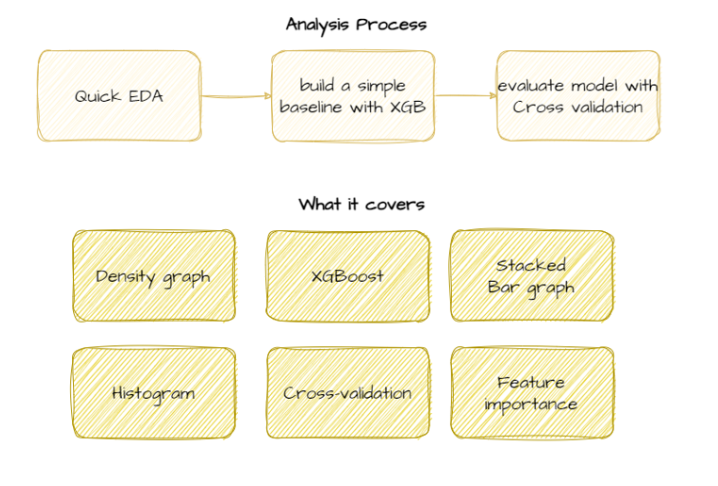

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>📊 Data description:</font></h3>

* Clonesize m2 The average blueberry clone size in the field
* Honeybee bees/m2/min Honeybee density in the field
* Bumbles bees/m2/min Bumblebee density in the field
* Andrena bees/m2/min Andrena bee density in the field
* Osmia bees/m2/min Osmia bee density in the field
* MaxOfUpperTRange ℃ The highest record of the upper band daily air temperature during the bloom season
* MinOfUpperTRange ℃ The lowest record of the upper band daily air temperature
* AverageOfUpperTRange ℃ The average of the upper band daily air temperature
* MaxOfLowerTRange ℃ The highest record of the lower band daily air temperature
* MinOfLowerTRange ℃ The lowest record of the lower band daily air temperature
* AverageOfLowerTRange ℃ The average of the lower band daily air temperature
* RainingDays Day The total number of days during the bloom season, each of which has precipitation larger than zero
* AverageRainingDays Day The average of raining days of the entire bloom season
    
* yield - Target variable
    
**  there's no descriptions of fruits-related variables T_T **

In [ ]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [ ]:
train = pd.read_csv("/kaggle/input/playground-series-s3e14/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e14/test.csv")

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Brief EDA</p>

In [ ]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Summary of EDA:</font></h3>

* There are 16 X variables and 1 target(y) variable, while 1 variable(id) is extra data
    
* No missing values on each columns~!
    
* All variables are float64 type. 

In [ ]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove('id')

In [ ]:
sns.displot(train, x="yield")

> #### ✔️ target value is normally distributed

In [ ]:
# kudos to @jcaliz /  
# refer to https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
#     sns.kdeplot(
#         original[column], label='Original',
#         ax=ax[i], color='#20BEFF'
#     )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* Distiribution between train and test dataset is almost the same.

* As all variables are numerical, you need to scale it if you want to use linear methods.

In [ ]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* TRange variables are highly correlated.
* fruitmass and fruitset , fruitmass and seed are highly correlated with each other.


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Baseline modeling with XGB</p>

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>modeling overview:</u></b><br>
    
* <i> build baseline model without hyperparameter tuning.</i><br>
* <i> 3-fold cross validation methods are used for baseline modeling.</i><br>
* <i> Evalution metric is mean absolute error</i><br>
    
</div>

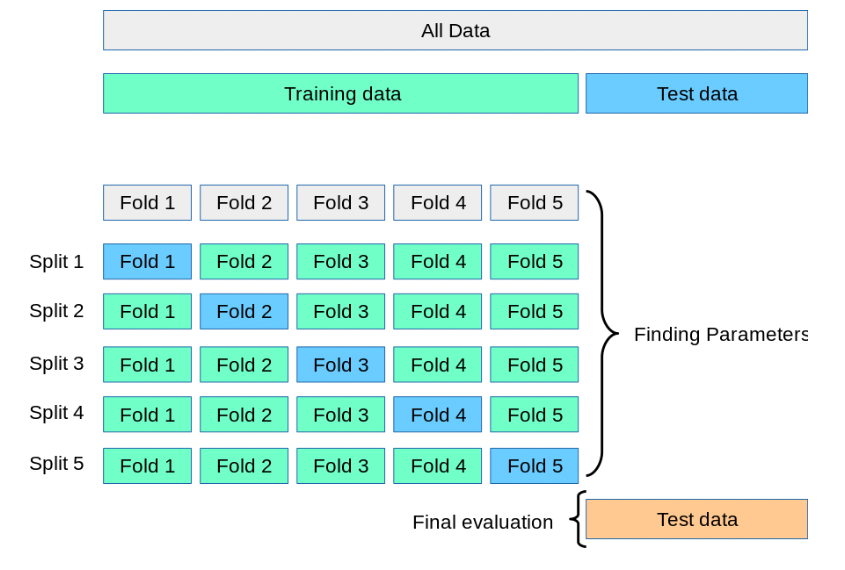

In [ ]:
train.drop('id',axis=1, inplace=True)

In [ ]:
X = train.drop('yield',axis=1)
Y = train['yield']

In [ ]:
test.set_index('id',inplace=True)

In [ ]:
from sklearn.metrics import mean_absolute_error

cv_scores = list()
importance_xgb = list()
preds = list()

## Running 3 fold CV
for i in range(3):
    print(f'{i} fold cv begin')
    skf = KFold(n_splits = 3, random_state = 1004, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              objective = 'reg:squarederror',
                              colsample_bytree = 0.8, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 5, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.8).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test)
        
        # Calculate RMSE
        cv_scores.append(mean_absolute_error(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)
        print(f'{i} fold cv done')

scores = np.mean(cv_scores)    
print('The average RMSE over 3-folds (run 3 times) is:', scores)

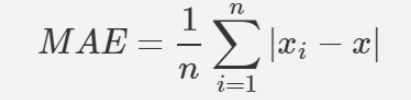

> #### MAE is a popular metric to use as the error value is easily interpreted. This is because the value is on the same scale as the target you are predicting for.
> #### Comparing with RMSE !
> ##### RMSE is more sensitive to outliers
> ##### RMSE penalises large errors more than MAE due to the fact that errors are squared initially
> ##### MAE returns values that are more interpretable as it is simply the average of absolute error

In [ ]:
plt.figure(figsize = (8, 8))
pd.DataFrame(importance_xgb, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('Feature importance score')
plt.ylabel('Features')
plt.show(); 

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights: :</font></h3>

* fruitset and seed are two most important features.
    
* however, these variables are highly correlated, as you know.

 

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>✔️ Conclusion:</font></h3>

* As we skipped feature engineering process, this result might be different once you apply scaling and other feature engineering methods.
* The average MAE over 3-folds (run 3 times) is: 352.1 , this is slightly better than benchmark.
* 😊 this is a simple baseline for beginners. you can 1) adjust hyper-parameter (HP tuning) ; 2) try different algorithms ; 3) add more feature engineered data to improve the performance.